In [22]:
import pandas as pd
import numpy as np
import ipaddress
import dns.resolver
import dns.reversename
import pygeoip
import matplotlib.pyplot as plt 

# datafile='./dataset9/test9.parquet'
datafile='./dataset9/data9.parquet'

data=pd.read_parquet(datafile)
# Initialize GeoIP databases
gi = pygeoip.GeoIP('./GeoIP_DBs/GeoIP.dat')
gi2 = pygeoip.GeoIP('./GeoIP_DBs/GeoIPASNum.dat')


In [3]:
addr='193.136.713.58'

ip_present = addr in data['src_ip'].values or addr in data['dst_ip'].values

if ip_present:
    # Perform geolocation lookup
    cc = gi.country_code_by_addr(addr)
    org = gi2.org_by_addr(addr)

    print("cc: ", cc, "org: ", org)
else:
    print(f"The IP address {addr} is not present in the dataset.")


The IP address 193.136.713.58 is not present in the dataset.



# Identify the range of internal IP addresses and verify which ones are considered internal devices.

In [14]:
# Define internal IP ranges (assuming IPv4 and internal IPs are in the private ranges)
internal_ip_ranges = ['192.168.', '10.', '172.16.', '172.17.', '172.18.', '172.19.', '172.20.', '172.21.', '172.22.', '172.23.', '172.24.', '172.25.', '172.26.', '172.27.', '172.28.', '172.29.', '172.30.', '172.31.']

# Filter data for internal IP addresses
internal_data = data[data['dst_ip'].str.startswith(tuple(internal_ip_ranges))]

# Group by destination IP and port to identify internal servers/services
internal_services = internal_data.groupby(['dst_ip', 'port']).agg({'up_bytes': 'sum', 'down_bytes': 'sum', 'dst_ip': 'count'}).rename(columns={'dst_ip': 'connections'})

# Sort by number of connections to identify most accessed internal servers/services
internal_services_sorted = internal_services.sort_values(by='connections', ascending=False)

print(internal_services_sorted)

                       up_bytes  down_bytes  connections
dst_ip          port                                    
192.168.109.227 443   907794569  8385777523        79358
192.168.109.224 443   896463953  8272980644        78711
192.168.109.230 53     10883873    24992469        54359
192.168.109.225 53     10719918    24593506        53517


# Look for IP addresses that frequently serve traffic and the ports they use (e.g., HTTP on port 80, HTTPS on port 443, DNS on port 53).

In [18]:
# Define the internal IP range prefix
internal_ip_prefix = '192.168.109.'

# Filter data for internal IP addresses
internal_data = data[data['dst_ip'].str.startswith(internal_ip_prefix)]

# Group by destination IP and port to identify internal servers/services
internal_services = internal_data.groupby(['dst_ip', 'port']).agg({'up_bytes': 'sum', 'down_bytes': 'sum', 'dst_ip': 'count'}).rename(columns={'dst_ip': 'connections'})

# Sort by number of connections to identify most accessed internal servers/services
internal_services_sorted = internal_services.sort_values(by='connections', ascending=False)

print(internal_services_sorted)

                       up_bytes  down_bytes  connections
dst_ip          port                                    
192.168.109.227 443   907794569  8385777523        79358
192.168.109.224 443   896463953  8272980644        78711
192.168.109.230 53     10883873    24992469        54359
192.168.109.225 53     10719918    24593506        53517


# Calculate the average upload and download bytes for internal-to-internal traffic flows.


Typical Internal to Internal Traffic Volume (mean):
up_bytes      4.564656e+08
down_bytes    4.177086e+09
dtype: float64


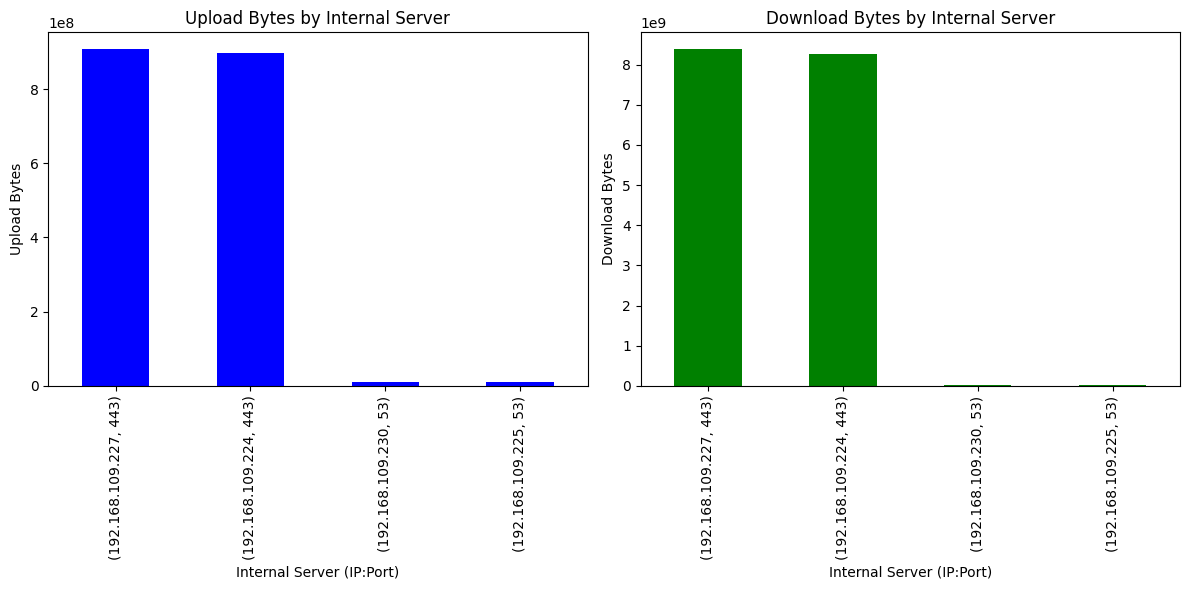

In [19]:
# Calculate typical traffic volume (mean) for internal-to-internal traffic
internal_to_internal_mean = internal_services_sorted[['up_bytes', 'down_bytes']].mean()

print("Typical Internal to Internal Traffic Volume (mean):")
print(internal_to_internal_mean)

# Plot traffic volumes
plt.figure(figsize=(12, 6))

# Upload bytes by server
plt.subplot(1, 2, 1)
internal_services_sorted['up_bytes'].plot(kind='bar', color='blue')
plt.title('Upload Bytes by Internal Server')
plt.xlabel('Internal Server (IP:Port)')
plt.ylabel('Upload Bytes')

# Download bytes by server
plt.subplot(1, 2, 2)
internal_services_sorted['down_bytes'].plot(kind='bar', color='green')
plt.title('Download Bytes by Internal Server')
plt.xlabel('Internal Server (IP:Port)')
plt.ylabel('Download Bytes')

plt.tight_layout()
plt.show()

# Calculate the average upload and download bytes for internal-to-external traffic flows.

Typical External to Public Server Traffic Volume (mean):
up_bytes      3.762933e+07
down_bytes    3.198378e+08
dtype: float64


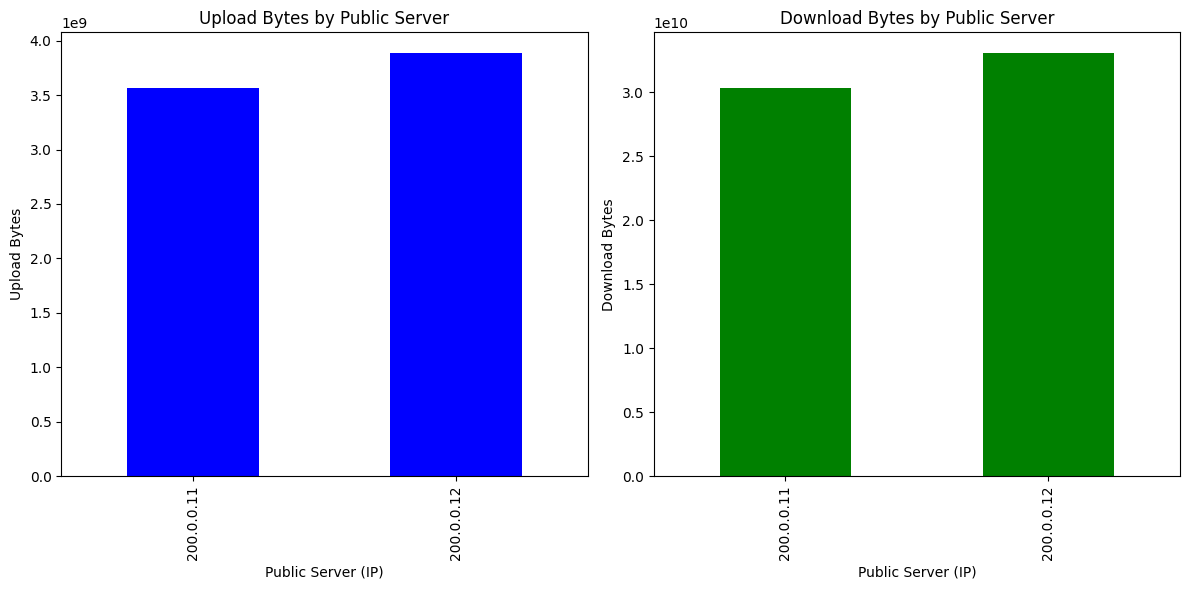

In [23]:
datafile='./dataset9/servers9.parquet'
data=pd.read_parquet(datafile)

# Define the public server IP range prefix (assuming external traffic to 200.0.0.X)
public_server_ip_prefix = '200.0.0.'

# Function to check if an IP is within the public server range
def is_public_server(ip):
    return ip.startswith(public_server_ip_prefix)

# Add a column to classify the destination IP as a public server
data['dst_public_server'] = data['dst_ip'].apply(is_public_server)

# Filter data for external-to-public server traffic
external_to_public = data[~data['src_ip'].str.startswith(internal_ip_prefix) & data['dst_public_server']]

# Group and aggregate traffic data for external-to-public server traffic
traffic_external_to_public = external_to_public.groupby(['src_ip', 'dst_ip']).agg({'up_bytes': 'sum', 'down_bytes': 'sum'}).reset_index()

# Calculate typical traffic volume (mean) for external-to-public server traffic
typical_external_to_public = traffic_external_to_public[['up_bytes', 'down_bytes']].mean()

print("Typical External to Public Server Traffic Volume (mean):")
print(typical_external_to_public)

# Visualize external-to-public server traffic
plt.figure(figsize=(12, 6))

# Upload bytes by public server
plt.subplot(1, 2, 1)
traffic_external_to_public.groupby('dst_ip')['up_bytes'].sum().plot(kind='bar', color='blue')
plt.title('Upload Bytes by Public Server')
plt.xlabel('Public Server (IP)')
plt.ylabel('Upload Bytes')

# Download bytes by public server
plt.subplot(1, 2, 2)
traffic_external_to_public.groupby('dst_ip')['down_bytes'].sum().plot(kind='bar', color='green')
plt.title('Download Bytes by Public Server')
plt.xlabel('Public Server (IP)')
plt.ylabel('Download Bytes')

plt.tight_layout()
plt.show()


# Code for Comparative Analysis:

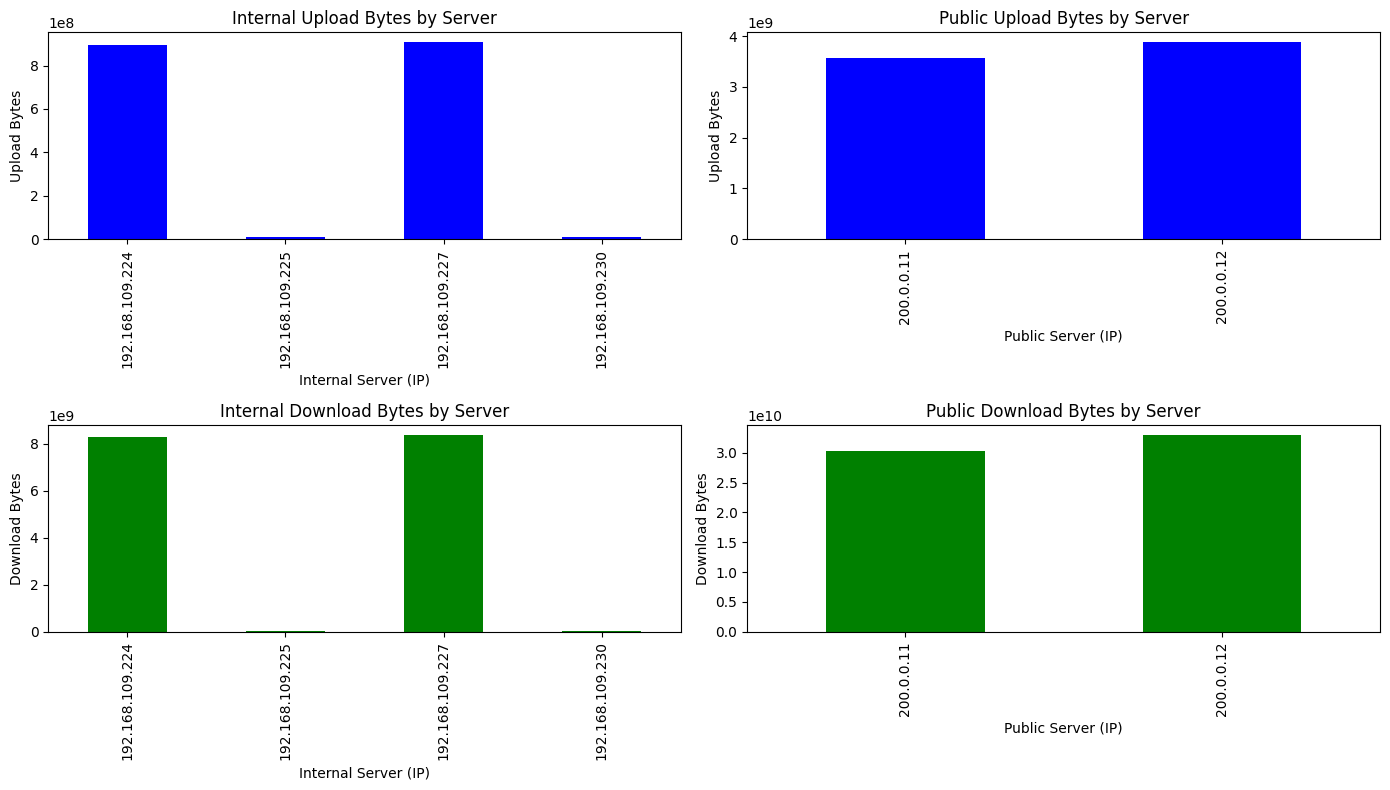

Typical Internal to Internal Traffic Volume (mean):
up_bytes      2.305382e+06
down_bytes    2.109639e+07
dtype: float64
Typical External to Public Server Traffic Volume (mean):
up_bytes      3.762933e+07
down_bytes    3.198378e+08
dtype: float64


In [24]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the datasets
internal_datafile = './dataset9/data9.parquet'
public_datafile = './dataset9/servers9.parquet'

internal_data = pd.read_parquet(internal_datafile)
public_data = pd.read_parquet(public_datafile)

# Define the internal and public server IP ranges
internal_ip_prefix = '192.168.109.'
public_ip_prefix = '200.0.0.'

# Function to check if an IP is within a specific range
def is_internal(ip):
    return ip.startswith(internal_ip_prefix)

def is_public_server(ip):
    return ip.startswith(public_ip_prefix)

# Classify IPs as internal, external, or public server
internal_data['dst_internal'] = internal_data['dst_ip'].apply(is_internal)
internal_data['src_internal'] = internal_data['src_ip'].apply(is_internal)
public_data['dst_public_server'] = public_data['dst_ip'].apply(is_public_server)

# Internal-to-Internal Traffic
internal_to_internal = internal_data[internal_data['src_internal'] & internal_data['dst_internal']]
traffic_internal = internal_to_internal.groupby(['src_ip', 'dst_ip']).agg({'up_bytes': 'sum', 'down_bytes': 'sum'}).reset_index()
typical_internal = traffic_internal[['up_bytes', 'down_bytes']].mean()

# External-to-Public Traffic
external_to_public = public_data[~public_data['src_ip'].str.startswith(internal_ip_prefix) & public_data['dst_public_server']]
traffic_external_to_public = external_to_public.groupby(['src_ip', 'dst_ip']).agg({'up_bytes': 'sum', 'down_bytes': 'sum'}).reset_index()
typical_external_to_public = traffic_external_to_public[['up_bytes', 'down_bytes']].mean()

# Visualization
plt.figure(figsize=(14, 8))

# Upload bytes comparison
plt.subplot(2, 2, 1)
traffic_internal.groupby('dst_ip')['up_bytes'].sum().plot(kind='bar', color='blue', label='Internal')
plt.title('Internal Upload Bytes by Server')
plt.xlabel('Internal Server (IP)')
plt.ylabel('Upload Bytes')

plt.subplot(2, 2, 2)
traffic_external_to_public.groupby('dst_ip')['up_bytes'].sum().plot(kind='bar', color='blue', label='Public')
plt.title('Public Upload Bytes by Server')
plt.xlabel('Public Server (IP)')
plt.ylabel('Upload Bytes')

# Download bytes comparison
plt.subplot(2, 2, 3)
traffic_internal.groupby('dst_ip')['down_bytes'].sum().plot(kind='bar', color='green', label='Internal')
plt.title('Internal Download Bytes by Server')
plt.xlabel('Internal Server (IP)')
plt.ylabel('Download Bytes')

plt.subplot(2, 2, 4)
traffic_external_to_public.groupby('dst_ip')['down_bytes'].sum().plot(kind='bar', color='green', label='Public')
plt.title('Public Download Bytes by Server')
plt.xlabel('Public Server (IP)')
plt.ylabel('Download Bytes')

plt.tight_layout()
plt.show()

print("Typical Internal to Internal Traffic Volume (mean):")
print(typical_internal)

print("Typical External to Public Server Traffic Volume (mean):")
print(typical_external_to_public)
